In [3]:
import sys
sys.path.insert(0, "../")
sys.path.insert(0, "./cifar-10-100n/")

import os
import torch
from PIL import Image as im
import pandas as pd
import numpy as np
from autogluon.vision import ImagePredictor, ImageDataset
import pickle
import datetime
from pathlib import Path
import cleanlab

from data.datasets import input_dataset
from cross_validation_autogluon import cross_val_predict_autogluon_image_dataset, train_predict_autogluon

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)

## Read data

In [4]:
# get labels
noise_file = torch.load('./data/CIFAR-10_human.pt')
clean_label = noise_file['clean_label']
worst_label = noise_file['worse_label']
aggre_label = noise_file['aggre_label']
random_label1 = noise_file['random_label1']
random_label2 = noise_file['random_label2']
random_label3 = noise_file['random_label3']

In [5]:
# get data
dataset = "cifar10"
noise_type = "worse_label"
noise_path = "./data/CIFAR-10_human.pt"
is_human = True

train_dataset, test_dataset, num_classes, num_training_samples = \
    input_dataset(dataset, noise_type, noise_path, is_human)

Files already downloaded and verified
Loaded worse_label from ./data/CIFAR-10_human.pt.
The overall noise rate is 0.40208
noisy labels loaded from ./data/CIFAR-10_human.pt
The noisy data ratio in each class is [0.10618 0.12106 0.10684 0.09346 0.0808  0.11336 0.08406 0.10546 0.09258
 0.0962 ]
over all noise rate is  0.40208


In [6]:
print(f"Accuracy of noisy labels vs true labels: {(worst_label == clean_label).mean()}")

Accuracy of noisy labels vs true labels: 0.59792


In [7]:
# classes
classes = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

## Manually inspect some images

Datapoint index: 19880
  Noisy Label: 7, horse
  True Label: 1, automobile


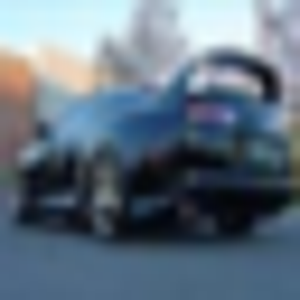

In [8]:
# check out some images
idx = 19880

# pick random image to inspect
# idx = np.random.randint(0, train_dataset.train_data.shape[0])

X = train_dataset.train_data[idx]
noisy_label = train_dataset.train_noisy_labels[idx]
true_label = train_dataset.train_labels[idx]

print(f"Datapoint index: {idx}")
print(f"  Noisy Label: {noisy_label}, {classes[noisy_label]}")
print(f"  True Label: {true_label}, {classes[true_label]}")

newsize = (300, 300) # zoom in

im.fromarray(X).resize(newsize)

Datapoints to inspect further:

Datapoints (index) where the true label is wrong
  14023 (true label is airplane but looks like a bird)

## Save images to folder

AutoGluon image models require the data to be image files in a folder

We'll save the images as PNG files in a single folder and save their file paths in a list

In [10]:
%%time

# create folder
SAVE_PATH = "./cifar-10n-png/train/"
# os.makedirs(SAVE_PATH)

# save images to folder

image_file_paths = [] # list of image file paths

for i, data in enumerate(train_dataset.train_data):
    
    # convert data to image object
    image = im.fromarray(data) 

    # path to image PNG file
    png_file = f"{SAVE_PATH}image_id_{i}.png"
    
    # print the number of images saved
    print(f"Images saved: {i + 1}", end="\r")
    
    # append file to list of file paths
    image_file_paths.append(png_file)
    
    # save image as PNG
    image.save(png_file)

CPU times: user 16.9 s, sys: 3.34 s, total: 20.2 s
Wall time: 20.2 s


## Create DataFrame to use as input for AutoGluon Image predictor

In [11]:
# Note: AutoGluon requires the column names to be "image" and "label"
df_train = pd.DataFrame({
    "image": image_file_paths,
    "label": train_dataset.train_noisy_labels, # noisy labels
    "true_label": train_dataset.train_labels # true labels
})

In [12]:
df_train.reset_index().to_csv("cifar-10n-dataset-noise-type-worse.csv", index=False)

In [13]:
assert (clean_label == df_train.true_label.values).all()

# Optional: copy the images to a faster drive (e.g. M.2 SSD) which will speedup training

In [ ]:
# !cp -r ./cifar-10n-png/ /Data/cifar-10n-png/

In [ ]:
# !ls /Data/cifar-10n-png

In [ ]:
# # add prefix to file path if we moved it to another drive
# prefix = "/Data/"
# df_train["image"] = df_train.image.map(lambda f: str(Path(prefix + f)))
# df_train.head()

In [ ]:
# !ls /Data

## Generate In-Sample Predicted Probabilities

In [16]:
%%time

# generate cross-validated predicted probabilities for various models so we can use them for ensemble scoring methods
models = [
    "resnet18",
    "resnet50d",
    "efficientnet_b1",
    "twins_pcpvt_base",
    "swin_base_patch4_window7_224"
]

epochs = 100
holdout_frac = 0.2
n_splits = 5

# run cross-validation for each model
for model in models:
    
    print("----")
    print(f"Running cross-validation for model: {model}")

    MODEL_PARAMS = {
        "model": model,
        "epochs": epochs,
        "holdout_frac": holdout_frac,
    }

    # results of cross-validation will be saved to pickle files for each model/fold
    _ = \
        train_predict_autogluon(
            dataset=df_train, # train with NOISY LABELS
            classes=classes,
            out_folder=f"./noxval_cifar-10n-png_noise_type_worst_cv_{model}/", # save results of cross-validation in pickle files for each fold
            n_splits=n_splits,
            model_params=MODEL_PARAMS,
            time_limit=60,
        )

    np.save(f"./noxval_cifar-10n-png_noise_type_worst_cv_{model}/true_labels.npy", df_train.true_label)

modified configs(<old> != <new>): {
root.misc.num_workers 4 != 8
root.misc.seed       42 != 501
root.img_cls.model   resnet101 != resnet18
root.train.batch_size 32 != 16
root.train.epochs    200 != 100
root.train.early_stop_baseline 0.0 != -inf
root.train.early_stop_max_value 1.0 != inf
root.train.early_stop_patience -1 != 10
}
Saved config to /home/ubuntu/label-error-detection-benchmarks/src/experiments/cifar-10n-worst/382f508a/.trial_0/config.yaml


----
Running cross-validation for model: resnet18


Model resnet18 created, param count:                                         11181642
AMP not enabled. Training in float32.
Disable EMA as it is not supported for now.
Start training from [Epoch 0]
Epoch[0] Batch [49]	Speed: 355.885489 samples/sec	accuracy=0.102500	lr=0.000100
Epoch[0] Batch [99]	Speed: 591.384551 samples/sec	accuracy=0.111875	lr=0.000100
Epoch[0] Batch [149]	Speed: 593.986570 samples/sec	accuracy=0.135000	lr=0.000100
Epoch[0] Batch [199]	Speed: 592.587088 samples/sec	accuracy=0.144687	lr=0.000100
Epoch[0] Batch [249]	Speed: 589.996977 samples/sec	accuracy=0.153500	lr=0.000100
Epoch[0] Batch [299]	Speed: 603.552015 samples/sec	accuracy=0.164167	lr=0.000100
Epoch[0] Batch [349]	Speed: 604.846460 samples/sec	accuracy=0.169821	lr=0.000100
Epoch[0] Batch [399]	Speed: 583.462391 samples/sec	accuracy=0.175937	lr=0.000100
Epoch[0] Batch [449]	Speed: 603.764329 samples/sec	accuracy=0.183611	lr=0.000100
Epoch[0] Batch [499]	Speed: 609.272022 samples/sec	accuracy=0.189500	lr=0.0

Saving to numpy files in this folder: ./noxval_cifar-10n-png_noise_type_worst_cv_resnet18/
Folder ./noxval_cifar-10n-png_noise_type_worst_cv_resnet18/ already exists!


modified configs(<old> != <new>): {
root.misc.num_workers 4 != 8
root.misc.seed       42 != 119
root.img_cls.model   resnet101 != resnet50d
root.train.batch_size 32 != 16
root.train.epochs    200 != 100
root.train.early_stop_baseline 0.0 != -inf
root.train.early_stop_max_value 1.0 != inf
root.train.early_stop_patience -1 != 10
}
Saved config to /home/ubuntu/label-error-detection-benchmarks/src/experiments/cifar-10n-worst/8c60b904/.trial_0/config.yaml


----
Running cross-validation for model: resnet50d


Model resnet50d created, param count:                                         23547754
AMP not enabled. Training in float32.
Disable EMA as it is not supported for now.
Start training from [Epoch 0]
Epoch[0] Batch [49]	Speed: 191.518665 samples/sec	accuracy=0.098750	lr=0.000100
Epoch[0] Batch [99]	Speed: 241.249286 samples/sec	accuracy=0.101250	lr=0.000100
Epoch[0] Batch [149]	Speed: 241.143890 samples/sec	accuracy=0.098333	lr=0.000100
Epoch[0] Batch [199]	Speed: 241.098927 samples/sec	accuracy=0.104688	lr=0.000100
Epoch[0] Batch [249]	Speed: 240.384232 samples/sec	accuracy=0.105500	lr=0.000100
Epoch[0] Batch [299]	Speed: 240.868136 samples/sec	accuracy=0.113333	lr=0.000100
Epoch[0] Batch [349]	Speed: 241.382259 samples/sec	accuracy=0.124107	lr=0.000100
Epoch[0] Batch [399]	Speed: 241.405634 samples/sec	accuracy=0.130469	lr=0.000100
Epoch[0] Batch [449]	Speed: 241.162729 samples/sec	accuracy=0.132500	lr=0.000100
Epoch[0] Batch [499]	Speed: 241.215762 samples/sec	accuracy=0.135250	lr=0.

Saving to numpy files in this folder: ./noxval_cifar-10n-png_noise_type_worst_cv_resnet50d/
Folder ./noxval_cifar-10n-png_noise_type_worst_cv_resnet50d/ already exists!


modified configs(<old> != <new>): {
root.misc.num_workers 4 != 8
root.misc.seed       42 != 482
root.img_cls.model   resnet101 != efficientnet_b1
root.train.batch_size 32 != 16
root.train.epochs    200 != 100
root.train.early_stop_baseline 0.0 != -inf
root.train.early_stop_max_value 1.0 != inf
root.train.early_stop_patience -1 != 10
}
Saved config to /home/ubuntu/label-error-detection-benchmarks/src/experiments/cifar-10n-worst/0b69d312/.trial_0/config.yaml


----
Running cross-validation for model: efficientnet_b1


Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-weights/efficientnet_b1-533bc792.pth" to /home/ubuntu/.cache/torch/hub/checkpoints/efficientnet_b1-533bc792.pth
Model efficientnet_b1 created, param count:                                         6525994
AMP not enabled. Training in float32.
Disable EMA as it is not supported for now.
Start training from [Epoch 0]
Epoch[0] Batch [49]	Speed: 139.960632 samples/sec	accuracy=0.110000	lr=0.000100
Epoch[0] Batch [99]	Speed: 217.172398 samples/sec	accuracy=0.123125	lr=0.000100
Epoch[0] Batch [149]	Speed: 219.273969 samples/sec	accuracy=0.129583	lr=0.000100
Epoch[0] Batch [199]	Speed: 217.326954 samples/sec	accuracy=0.133437	lr=0.000100
Epoch[0] Batch [249]	Speed: 218.261559 samples/sec	accuracy=0.139750	lr=0.000100
Epoch[0] Batch [299]	Speed: 216.866270 samples/sec	accuracy=0.145000	lr=0.000100
Epoch[0] Batch [349]	Speed: 219.237092 samples/sec	accuracy=0.145714	lr=0.000100
Epoch[0] Batch [399]	Speed: 219.

Saving to numpy files in this folder: ./noxval_cifar-10n-png_noise_type_worst_cv_efficientnet_b1/


modified configs(<old> != <new>): {
root.misc.num_workers 4 != 8
root.misc.seed       42 != 168
root.img_cls.model   resnet101 != twins_pcpvt_base
root.train.batch_size 32 != 16
root.train.epochs    200 != 100
root.train.early_stop_baseline 0.0 != -inf
root.train.early_stop_max_value 1.0 != inf
root.train.early_stop_patience -1 != 10
}
Saved config to /home/ubuntu/label-error-detection-benchmarks/src/experiments/cifar-10n-worst/c8490a94/.trial_0/config.yaml


----
Running cross-validation for model: twins_pcpvt_base


Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-vt3p-weights/twins_pcpvt_base-e5ecb09b.pth" to /home/ubuntu/.cache/torch/hub/checkpoints/twins_pcpvt_base-e5ecb09b.pth
Model twins_pcpvt_base created, param count:                                         43320586
AMP not enabled. Training in float32.
Disable EMA as it is not supported for now.
Start training from [Epoch 0]
Epoch[0] Batch [49]	Speed: 88.062756 samples/sec	accuracy=0.113750	lr=0.000100
Epoch[0] Batch [99]	Speed: 118.196650 samples/sec	accuracy=0.161875	lr=0.000100
Epoch[0] Batch [149]	Speed: 117.730685 samples/sec	accuracy=0.190417	lr=0.000100
Epoch[0] Batch [199]	Speed: 117.941093 samples/sec	accuracy=0.220312	lr=0.000100
Epoch[0] Batch [249]	Speed: 119.045004 samples/sec	accuracy=0.254750	lr=0.000100
Epoch[0] Batch [299]	Speed: 119.635078 samples/sec	accuracy=0.279167	lr=0.000100
Epoch[0] Batch [349]	Speed: 119.578690 samples/sec	accuracy=0.294643	lr=0.000100
Epoch[0] Batch [399]	Spe

Saving to numpy files in this folder: ./noxval_cifar-10n-png_noise_type_worst_cv_twins_pcpvt_base/


modified configs(<old> != <new>): {
root.misc.num_workers 4 != 8
root.misc.seed       42 != 757
root.img_cls.model   resnet101 != swin_base_patch4_window7_224
root.train.batch_size 32 != 16
root.train.epochs    200 != 100
root.train.early_stop_baseline 0.0 != -inf
root.train.early_stop_max_value 1.0 != inf
root.train.early_stop_patience -1 != 10
}
Saved config to /home/ubuntu/label-error-detection-benchmarks/src/experiments/cifar-10n-worst/d96c670c/.trial_0/config.yaml


----
Running cross-validation for model: swin_base_patch4_window7_224


Downloading: "https://github.com/SwinTransformer/storage/releases/download/v1.0.0/swin_base_patch4_window7_224_22kto1k.pth" to /home/ubuntu/.cache/torch/hub/checkpoints/swin_base_patch4_window7_224_22kto1k.pth
Model swin_base_patch4_window7_224 created, param count:                                         86753474
AMP not enabled. Training in float32.
Disable EMA as it is not supported for now.
Start training from [Epoch 0]
Epoch[0] Batch [49]	Speed: 65.248610 samples/sec	accuracy=0.147500	lr=0.000100
Epoch[0] Batch [99]	Speed: 79.298717 samples/sec	accuracy=0.173750	lr=0.000100
Epoch[0] Batch [149]	Speed: 73.030239 samples/sec	accuracy=0.208333	lr=0.000100
Epoch[0] Batch [199]	Speed: 79.475453 samples/sec	accuracy=0.243438	lr=0.000100
Epoch[0] Batch [249]	Speed: 79.511323 samples/sec	accuracy=0.269500	lr=0.000100
`time_limit=59.999886989593506` reached, exit early...


Saving to numpy files in this folder: ./noxval_cifar-10n-png_noise_type_worst_cv_swin_base_patch4_window7_224/
CPU times: user 20min 18s, sys: 4min 31s, total: 24min 50s
Wall time: 27min 50s
